In [1]:
!pip install d2l

In [2]:
import torch
import torch.nn as nn
from d2l import torch as d2l

Shape of x: torch.Size([1000])


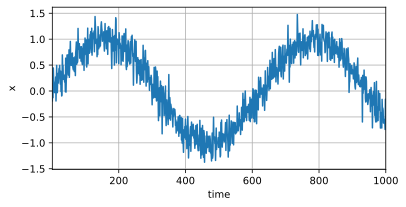

In [24]:
# Generate a total of 1000 points
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
print(f'Shape of x: {x.shape}')

d2l.plot(time, [x], 'time', 'x', xlim = [1,1000], figsize=(6,3))

Turn the above built sequence into features and labels that our model can train on.

Feature: $\textbf{x_t} = [x_{t-\tau}, ..., x_{t-1}]$ 

Label: $y_t = x_t$


In [6]:
tau = 4
features = torch.zeros((T-tau, tau))
print(f'Shape of features: {features.shape}')
for i in range(tau):
  features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape(-1,1)

print(f'Shape of labels: {labels.shape}')


batch_size, n_train = 16, 600
# only the first n_train examples are used for training.
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

Shape of features: torch.Size([996, 4])
Shape of labels: torch.Size([996, 1])


In [25]:
train_X,train_y = next(iter(train_iter))
print(train_X.shape, train_y.shape)

torch.Size([16, 4]) torch.Size([16, 1])


MLP with two fully connected layers, ReLU activation, squared loss

In [15]:
# function for initializing the weights of the model
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)

# A simpple MLP
def get_net():
  net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10,1))
  net.apply(init_weights)
  return net

# square loss
criterion = nn.MSELoss()

Train the model

In [18]:
def train(net, train_iter, criterion, epochs, lr):
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  for epoch in range(epochs):
    running_loss = 0.0
    for X, y in train_iter:
      optimizer.zero_grad()
      output = net(X)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      running_loss += loss
    print(f'Epoch: {epoch+1}/{epochs} Loss: {(running_loss / len(train_iter)):.6f}')

net = get_net()
train(net, train_iter, criterion, 5, 0.01)

Epoch: 1/5 Loss: 0.129734
Epoch: 2/5 Loss: 0.064464
Epoch: 3/5 Loss: 0.056938
Epoch: 4/5 Loss: 0.055240
Epoch: 5/5 Loss: 0.053750


**Prediction**

torch.Size([996, 1])


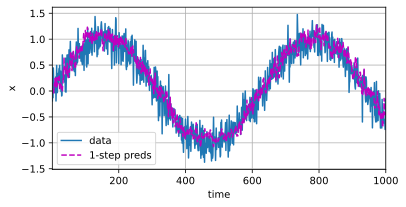

In [26]:
onestep_preds = net(features)
print(onestep_preds.shape)

d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

Multi-step ahead predictions

for an observed sequence up to $x_t$ , its predicted output  $\hat{x}_{t+k}$  at time step  $t+k$  is called the $k$ -step-ahead prediction.

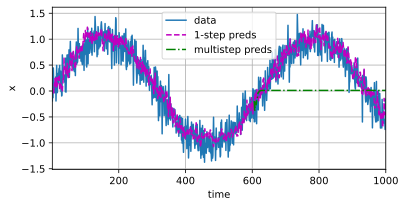

In [27]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train + tau, T):
  multistep_preds[i] = net(multistep_preds[i-tau:i].reshape(1,-1))

d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

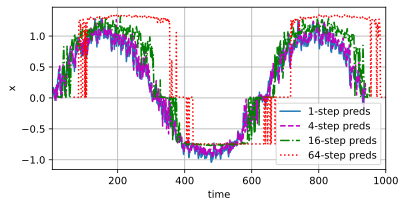

In [28]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))